In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers import TextVectorization
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Embedding, Bidirectional
from keras.metrics import Precision, Recall, CategoricalAccuracy

## Dataset

In [2]:
df=pd.read_csv("train.csv")
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
df["comment_text"].iloc[6]                                                #checking a hate comment from dataset

'COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK'

In [4]:
df[df.columns[2:]].iloc[6]

toxic            1
severe_toxic     1
obscene          1
threat           0
insult           1
identity_hate    0
Name: 6, dtype: int64

# Preprocessing

In [5]:
X=df['comment_text']
Y=df[df.columns[2:]].values


In [6]:
vectorizer=TextVectorization(
    max_tokens=200000,
    output_sequence_length=1000,
    output_mode='int',
)

In [7]:
vectorizer.adapt(X.values)

In [8]:
vector_text=vectorizer(X.values)

In [9]:
vector_text

<tf.Tensor: shape=(159571, 1000), dtype=int64, numpy=
array([[  645,    76,     2, ...,     0,     0,     0],
       [    1,    54,  2489, ...,     0,     0,     0],
       [  425,   441,    70, ...,     0,     0,     0],
       ...,
       [32445,  7392,   383, ...,     0,     0,     0],
       [    5,    12,   534, ...,     0,     0,     0],
       [    5,     8,   130, ...,     0,     0,     0]])>

### Data Pipeline

In [10]:
dataset=tf.data.Dataset.from_tensor_slices((vector_text, Y))    # or we can use list_files
dataset=dataset.cache()
dataset=dataset.shuffle(160000)
dataset=dataset.batch(16)
dataset=dataset.prefetch(8)                                     # helps prevent bottlenecks

In [11]:
train=dataset.take(int(len(dataset)*.6))
valid=dataset.skip(int(len(dataset)*.6)).take(int(len(dataset)*.2))
test=dataset.take(int(len(dataset)*.8)).take(int(len(dataset)*.2))

In [12]:
train_gen=train.as_numpy_iterator()

In [13]:
train_gen.next()

(array([[  981,    83,    15, ...,     0,     0,     0],
        [  823,   425,  2292, ...,     0,     0,     0],
        [    8,    59,   204, ...,     0,     0,     0],
        ...,
        [55598,   416,    10, ...,     0,     0,     0],
        [22712,   171,     2, ...,     0,     0,     0],
        [ 9316,  8571,     2, ...,     0,     0,     0]]),
 array([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]]))

# Building Model

In [14]:
model=Sequential()
model.add(Embedding(200000+1,32))
model.add(Bidirectional(LSTM(32,activation='tanh'))),               #tanh for LSTM
model.add(Dense(128,activation='relu')),
model.add(Dense(128,activation='relu')),
model.add(Dense(128,activation='relu')),
model.add(Dense(6,activation='sigmoid')),

(None,)

In [15]:
model.compile(
    optimizer='Adam',
    loss='BinaryCrossentropy',
)

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [17]:
history=model.fit(train, epochs=10, validation_data=valid)

Epoch 1/10
5984/5984 [==============================] - 466s 76ms/step - loss: 0.0641 - val_loss: 0.0482
Epoch 2/10
5984/5984 [==============================] - 327s 55ms/step - loss: 0.0472 - val_loss: 0.0409
Epoch 3/10
5984/5984 [==============================] - 319s 53ms/step - loss: 0.0426 - val_loss: 0.0395
Epoch 4/10
5984/5984 [==============================] - 318s 53ms/step - loss: 0.0385 - val_loss: 0.0358
Epoch 5/10
5984/5984 [==============================] - 315s 53ms/step - loss: 0.0361 - val_loss: 0.0306
Epoch 6/10
5984/5984 [==============================] - 318s 53ms/step - loss: 0.0328 - val_loss: 0.0279
Epoch 7/10
5984/5984 [==============================] - 322s 54ms/step - loss: 0.0296 - val_loss: 0.0254
Epoch 8/10
5984/5984 [==============================] - 323s 54ms/step - loss: 0.0269 - val_loss: 0.0247
Epoch 9/10
5984/5984 [==============================] - 321s 54ms/step - loss: 0.0248 - val_loss: 0.0243
Epoch 10/10
5984/5984 [==============================] 

<Figure size 800x500 with 0 Axes>

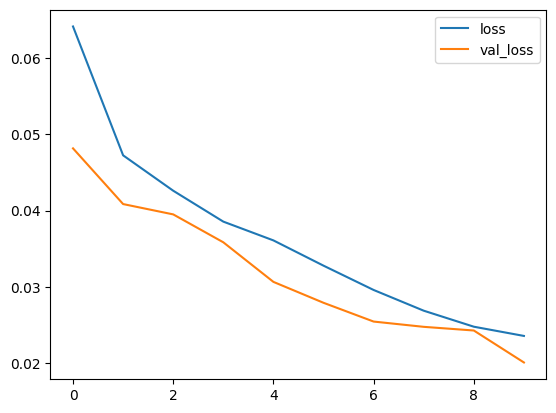

In [18]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

# Model Evaluation


In [26]:
pre=Precision()
rec=Recall()

In [27]:
for batch in test.as_numpy_iterator():

  X_true,Y_true=batch
  Y_true=Y_true.flatten()
  Y_pred=model.predict(X_true).flatten()

  pre.update_state(Y_true,Y_pred)
  rec.update_state(Y_true,Y_pred)

1/1 [==============================] - 0s 43ms/step


In [28]:
print(f'Precision: {pre.result().numpy()}, Recall:{rec.result().numpy()}')

Precision: 0.9213948249816895, Recall:0.8768278956413269


# Predictive System

In [30]:
test_gen=test.as_numpy_iterator()

In [31]:
input=vectorizer("I hate you")                          #Enter your custom text inside the ""

In [32]:
input_pred= model.predict(np.array([input]))
input_pred

1/1 [==============================] - 0s 35ms/step


array([[0.85682195, 0.00193901, 0.03886925, 0.00588744, 0.3648242 ,
        0.03420495]], dtype=float32)

In [33]:
for i in range(5):
  if input_pred[0][i]>0.5:
    print(df.columns[2+i],": ","YES",end="\t")
  else:
    print(df.columns[2+i],": ","NO",end="\t")

toxic :  YES	severe_toxic :  NO	obscene :  NO	threat :  NO	insult :  NO	